In [1]:
file_name='Classifier_202211241900.pth' # 副檔名通常以.pt或.pth儲存，建議使用.pth
import torch
device=torch.device('cuda') # 'cuda'/'cpu'，import torch
num_classes=10
train_size=50000
valid_size=10000
batch_size=1024
learning_rate=0.1
step_size=1000 # Reriod of learning rate decay
epochs=100

In [2]:
from torchvision import transforms,datasets
transforms=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307),(0.3081))]) # 標準化每個channel為均值0.1307、標準差0.3081，import torchvision
dataset=datasets.MNIST('',train=True,download=False,transform=transforms) # ''指資料存放在程式目前的資料夾，train=True時dataset為60000筆訓練資料，其中dataset.data：[60000,28,28]，dataset.targets：[60000]，train=False時dataset為10000筆測試資料，其中dataset.data：[10000,28,28]，dataset.targets：[10000]，import torchvision
train_data,valid_data=torch.utils.data.random_split(dataset,[train_size,valid_size]) # import torch
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True) # import torch
valid_loader=torch.utils.data.DataLoader(valid_data,batch_size=batch_size,shuffle=True) # import torch

In [3]:
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.layer3=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )        
        self.fc=nn.Linear(3*3*64,num_classes)

    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        return x

classifier=CNN().to(device)
criterion=nn.CrossEntropyLoss() # 分類
optimizer=torch.optim.Adadelta(classifier.parameters(),lr=learning_rate) # import torch
#optimizer=torch.optim.SGD(classifier.parameters(),lr=learning_rate) # import torch
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size,0.1) # import torch

In [4]:
import numpy 
train_acc_his,train_losses_his,valid_acc_his,valid_losses_his=[],[],[],[]
for i in range(1,epochs+1):
    print('Running Epoch:'+str(i))
    train_correct,train_loss,train_total,valid_correct,valid_loss,valid_total=0,0,0,0,0,0
    classifier.train()
    for img,cls in train_loader: # 一個batch的img、cls。img：[batch_size,1,28,28]，cls：[batch_size]
        img,cls=img.to(device),cls.to(device)
        pred=classifier(img) # pred：[batch_size,num_classes]
        loss=criterion(pred,cls) # loss.item()：一個batch的平均loss，[1]
        output_id=torch.max(pred,dim=1)[1] # output_id：網路輸出編號(0表示預測為第一個輸出)，[batch_size]
        train_correct+=numpy.sum(torch.eq(cls,output_id).cpu().numpy()) # 累加計算每一epoch正確預測總數，import numpy
        train_loss+=loss.item()*img.size(0) # 累加計算每一epoch的loss總和。loss.item()：一個batch的平均loss，[1]。img.size(0)：一個batch的訓練資料總數
        train_total+=img.size(0) # 累加計算訓練資料總數
        optimizer.zero_grad() # 權重梯度歸零
        loss.backward() # 計算每個權重的loss梯度
        optimizer.step() # 權重更新
    scheduler.step()

    classifier.eval()
    for img,cls in valid_loader: # 一個batch的img、cls。img：[batch_size,1,28,28]，cls：[batch_size]
        img,cls=img.to(device),cls.to(device)
        pred=classifier(img) # pred：[batch_size,num_classes]
        loss=criterion(pred,cls) # loss.item()：一個batch的平均loss，[1]
        output_id=torch.max(pred,dim=1)[1] # output_id：網路輸出編號(0表示預測為第一個輸出)，[batch_size]
        valid_correct+=numpy.sum(torch.eq(cls,output_id).cpu().numpy()) # 累加計算每一epoch正確預測總數
        valid_loss+=loss.item()*img.size(0) # 累加計算每一epoch的loss總和。loss.item()：一個batch的平均loss，[1]。img.size(0)：一個batch的驗證資料總數
        valid_total+=img.size(0) # 累加計算驗證資料總數

    train_acc=train_correct/train_total*100 # 計算每一個epoch的平均訓練正確率(%)
    train_loss=train_loss/train_total # 計算每一個epoch的平均訓練loss
    valid_acc=valid_correct/valid_total*100 # 計算每一個epoch的平均驗證正確率(%)
    valid_loss=valid_loss/valid_total # 計算每一個epoch的平均驗證loss
    train_acc_his.append(train_acc) # 累積紀錄每一個epoch的平均訓練正確率(%)，[epochs]
    train_losses_his.append(train_loss) # 累積記錄每一個epoch的平均訓練loss，[epochs]
    valid_acc_his.append(valid_acc) # 累積紀錄每一個epoch的平均驗證正確率(%)，[epochs]
    valid_losses_his.append(valid_loss) # 累積記錄每一個epoch的平均驗證loss，[epochs]
    print('Training Loss='+str(train_loss))
    print('Training Accuracy(%)='+str(train_acc))
    print('Validation Accuracy(%)='+str(valid_acc))

Running Epoch:1
Training Loss=0.8706426741409302
Training Accuracy(%)=80.962
Validation Accuracy(%)=93.94
Running Epoch:2
Training Loss=0.22571052587509155
Training Accuracy(%)=95.504
Validation Accuracy(%)=95.95
Running Epoch:3
Training Loss=0.13260504496574402
Training Accuracy(%)=96.99
Validation Accuracy(%)=97.46000000000001
Running Epoch:4
Training Loss=0.09239599944591523
Training Accuracy(%)=97.80799999999999
Validation Accuracy(%)=97.63
Running Epoch:5
Training Loss=0.07254406682252884
Training Accuracy(%)=98.2
Validation Accuracy(%)=97.92
Running Epoch:6
Training Loss=0.059348179502487185
Training Accuracy(%)=98.52199999999999
Validation Accuracy(%)=98.28
Running Epoch:7
Training Loss=0.0506449546957016
Training Accuracy(%)=98.746
Validation Accuracy(%)=98.37
Running Epoch:8
Training Loss=0.043797663551568985
Training Accuracy(%)=98.92800000000001
Validation Accuracy(%)=98.54
Running Epoch:9
Training Loss=0.038455686108469965
Training Accuracy(%)=99.116
Validation Accuracy(%)=

(-0.5, 27.5, 27.5, -0.5)

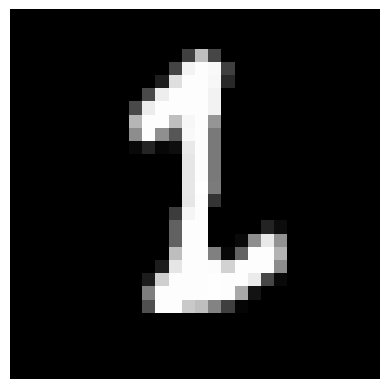

In [5]:
# 顯示第71筆訓練資料影像
import matplotlib.pyplot as plt
plt.imshow(dataset.data[70],cmap='gray') # 繪製點陣圖，cmap='gray'：灰階
plt.axis('off') # 隱藏刻度

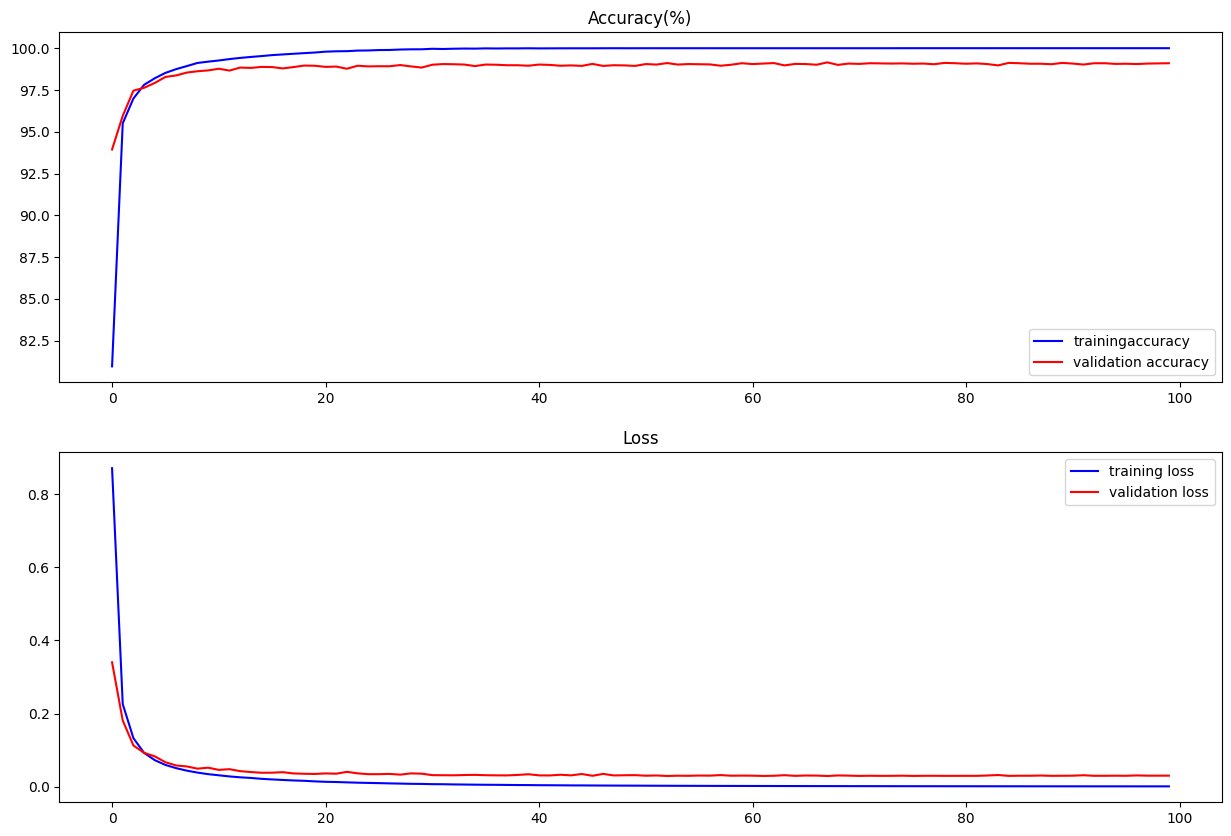

In [6]:
# 對訓練過程繪圖
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(train_acc_his,'b',label='trainingaccuracy')
plt.plot(valid_acc_his,'r',label='validation accuracy')
plt.title('Accuracy(%)')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(train_losses_his,'b',label='training loss')
plt.plot(valid_losses_his,'r',label='validation loss')
plt.title('Loss')
plt.legend(loc='best')
plt.show()

In [7]:
torch.save(classifier.state_dict(),file_name)